In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from logger import logger
import os
import cv2
import pydot
#-------------------------------------------------
import keras.backend as K
from keras.applications import inception_v3, inception_resnet_v2
from keras import callbacks as Kcallbacks
from keras.utils import plot_model
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Input, Activation, ZeroPadding2D, BatchNormalization,\
    Flatten, MaxPooling2D, Dropout, concatenate, AveragePooling2D
#-------------------------------------------------------------------------
from tensorflow import losses as tflosses
%matplotlib inline
np.random.seed(0)

In [2]:
train = np.load('./data/train/train_dataset.npy')
labels = np.load('./data/train/labels.npy')

In [3]:
def prepare_test_data() :
    test_dataset = np.load('./data/test/test_dataset.npy')
    test_ids = np.load('./data/test/ids.npy')
    print test_dataset.shape
    return test_dataset, test_ids

In [4]:
def get_more_images(imgs, epoches):
    
    more_images = []
    rotated_imgs = []
    for e in range(epoches) :
        for i in range(0,imgs.shape[0]):
            a=imgs[i,:,:,0]
            b=imgs[i,:,:,1]
            c=imgs[i,:,:,2]
            d=imgs[i,:,:,3]
            #roation = 
            M = cv2.getRotationMatrix2D( (a.shape[0]/2,a.shape[1]/2), np.random.randint(1,360), 1.5)

            a1 = cv2.warpAffine(a, M, a.shape)
            b1 = cv2.warpAffine(b, M, a.shape)
            c1 = cv2.warpAffine(c, M, a.shape)
            d1 = cv2.warpAffine(d, M, a.shape)
            
            rotated_imgs.append(np.dstack((a1,b1,c1,d1)))
            
            
    r = np.array(rotated_imgs)
       
    more_images = np.concatenate((imgs,r))
    
    return more_images

e = 5
train_ext = get_more_images(train, e)
labels_ext = np.concatenate([labels for i in range(e+1)])
print train_ext.shape
print labels_ext.shape

(9624, 75, 75, 4)
(9624, 1)


In [5]:
# getting validation set
train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(train_ext, labels_ext,
                                                                            test_size=.0000001,shuffle=True)


print train_dataset.shape, train_labels.shape
print valid_dataset.shape, valid_labels.shape

del train, labels, train_ext, labels_ext

(9623, 75, 75, 4) (9623, 1)
(1, 75, 75, 4) (1, 1)


------------------------

 ** An iceberg


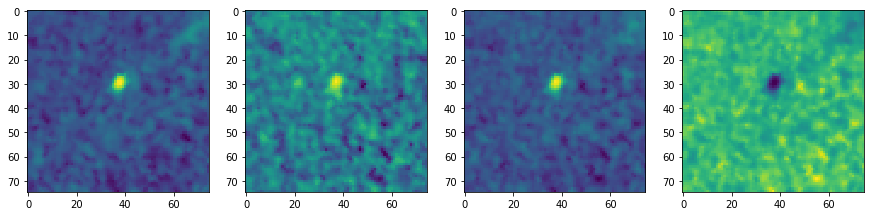

In [6]:
plt.rcParams["figure.figsize"] = [15,15]
index = np.random.randint(0, train_dataset.shape[0])
f, axarr = plt.subplots(1,4)
_ = axarr[0].imshow(train_dataset[index,:,:,0])
_ = axarr[1].imshow(train_dataset[index,:,:,1])
_ = axarr[2].imshow(train_dataset[index,:,:,2])
_ = axarr[3].imshow(train_dataset[index,:,:,3])

print " ** A ship" if train_labels[index,0] == 1 else " ** An iceberg"

In [ ]:
train_dataset = train_dataset[:,:,:,2:]

In [ ]:
def convolution_layer(X, layer_name, paddings, convC, convF, convS, poolF, poolS, droprate=.2):
    X = ZeroPadding2D(paddings, name='Zero_Padding_'+layer_name)(X)
    X = Conv2D(convC, convF, strides=convS, name='Conv2d_'+layer_name)(X)
    X = BatchNormalization(axis=3, name='BN_'+layer_name)(X)
    X = Activation('relu', name='relu_activ_'+layer_name)(X)
    X = MaxPooling2D(poolF, poolS, name='MaxPooling_'+layer_name)(X)
    X = Dropout(droprate, name='dropout_'+layer_name)(X)
    return X
#--------------------------------------------------------
def fullyconnected_layer(X, layer_name, dense_units, activ, droprate=.2):
    X = Dense(dense_units, activation=activ, name='Dense_'+layer_name)(X)
    if layer_name == 'output' : return X
    X = BatchNormalization( name='BN_'+layer_name)(X)
    X = Dropout(droprate, name='dropout_'+layer_name)(X)
    return X
#-----------------------------------------------------------------------
def get_model(input_shape):
    X_input = Input(input_shape, name= 'input')
    # layer 1
    X = convolution_layer(X_input, 'layer1', 3, 64,  3, 1, 3, 2, .5)
    X = convolution_layer(X,       'layer2', 2, 128, 3, 1, 2, 2, .5)
    X = convolution_layer(X,       'layer3', 2, 128, 3, 1, 2, 2, .5)
    X = convolution_layer(X,       'layer4', 2, 64,  3, 1, 2, 2, .5)
    #-*-*-*-*-*-**-*-*-*-*-*-*-*
    X = Flatten()(X)
    X = fullyconnected_layer(X, 'FC1', 512, 'relu', .5)
    X = fullyconnected_layer(X, 'FC2', 256, 'relu', .5)
    X = fullyconnected_layer(X, 'FC3', 256, 'relu', .5)
    X = fullyconnected_layer(X, 'output', 1, 'sigmoid')
    
    model = Model(inputs=X_input, outputs=X)
    return model
model = get_model([75,75,2])
model.summary()

In [13]:
def conv2d_bn(X, c, f, lname):
    X = Conv2D(c, f, strides=1, padding='same', name='Conv2d_'+lname)(X)
    X = BatchNormalization(axis=3, name='BN_'+lname)(X)
    X = Activation('relu', name='relu_activ_'+lname)(X)
    return X
#-------------------------------------------------------------------------------
def fullyconnected_layer(X, layer_name, dense_units, activ, droprate=.2):
    X = Dense(dense_units, activation=activ, name='Dense_'+layer_name)(X)
    if layer_name == 'output' : return X
    X = BatchNormalization( name='BN_'+layer_name)(X)
    X = Dropout(droprate, name='dropout_'+layer_name)(X)
    return X
#------------------------------------------------------------------------------
def get_model(input_shape):
    X_input = Input(input_shape, name='input')
    X = ZeroPadding2D(2, name='Zero_Padding_Input')(X_input)
    #-----------------------------------------------------
    # Inception Block 1
    branch1x1 = conv2d_bn(X, 32, 1, 'inception1_1x1')
    branch3x3 = conv2d_bn(X, 32, 3, 'inception1_3x3')
    branch5x5 = conv2d_bn(X, 32, 3, 'inception1_5x5')
    branchbool =  AveragePooling2D(3, strides=1, padding='SAME')(X)
    branchbool = conv2d_bn(branchbool, 32, 1, 'inception1_bool')
    X = concatenate([branch1x1, branch3x3, branch5x5, branchbool], axis=3, name='inception1_concat')
    #----------------------------------------------------
    # Inception Block 2
    X = ZeroPadding2D(2, name='Zero_padding_X_2')(X)
    branch1x1 = conv2d_bn(X, 64, 1, 'inception2_1x1')
    
    branch3x3 = conv2d_bn(X, 64, 1, 'inception2_3x3_1')
    branch3x3 = conv2d_bn(branch3x3, 64, 3, 'inception2_3x3_2')
    
    branch5x5 = conv2d_bn(X, 64, 1, 'inception2_5x5_1')
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 'inception2_5x5_2')
    
    branchbool = AveragePooling2D(3, strides=1, padding='SAME', name='inception2_bool_1')(X)
    branchbool = conv2d_bn(branchbool, 64, 1, 'inception2_bool_2')
    
    X = concatenate([branch1x1, branch3x3, branch5x5, branchbool], axis=3, name='inception2_concat')
    #-----------------------------------------------------
    # FC
    X = MaxPooling2D(5, strides=2)(X)
    X = Flatten()(X)
    X = fullyconnected_layer(X, 'FC_1', 512, 'relu', .2)
    X = fullyconnected_layer(X, 'output', 1, 'sigmoid')
    model = Model(inputs=X_input, outputs=X)
    return model
model = get_model([75,75,4])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 75, 75, 4)    0                                            
__________________________________________________________________________________________________
Zero_Padding_Input (ZeroPadding (None, 79, 79, 4)    0           input[0][0]                      
__________________________________________________________________________________________________
average_pooling2d_10 (AveragePo (None, 79, 79, 4)    0           Zero_Padding_Input[0][0]         
__________________________________________________________________________________________________
Conv2d_inception1_1x1 (Conv2D)  (None, 79, 79, 32)   160         Zero_Padding_Input[0][0]         
__________________________________________________________________________________________________
Conv2d_inc

In [8]:
model.compile(Adam(lr=.1), loss='binary_crossentropy',metrics=[])

In [9]:
callbacks = [ 
    Kcallbacks.EarlyStopping(patience=10, verbose=1, mode='min'),
    Kcallbacks.History(),
    Kcallbacks.CSVLogger('./tmp/keras/checkpoints/2/logger1.log', append=True),
    Kcallbacks.ReduceLROnPlateau(factor=.1, patience=7, verbose=1),
    Kcallbacks.ModelCheckpoint('./tmp/keras/checkpoints/2/ckpt-{val_loss:.4f}-{epoch:02d}.hdf5',
                               verbose=1, save_best_only=1, mode='min')
] 

model.fit(x=train_dataset, y=train_labels, batch_size=32, epochs=100, shuffle=True, verbose=1, 
          validation_split=.2, callbacks=callbacks)

Train on 7698 samples, validate on 1925 samples
Epoch 1/100
7698/7698 [==============================] - 897s 117ms/step - loss: 8.3875 - val_loss: 8.7373
Epoch 2/100
7698/7698 [==============================] - 859s 112ms/step - loss: 8.3875 - val_loss: 8.7373
Epoch 3/100
7698/7698 [==============================] - 853s 111ms/step - loss: 8.3875 - val_loss: 8.7373
Epoch 4/100
7698/7698 [==============================] - 850s 110ms/step - loss: 8.3875 - val_loss: 8.7373
Epoch 5/100
7698/7698 [==============================] - 850s 110ms/step - loss: 8.3875 - val_loss: 8.7373
Epoch 6/100
7698/7698 [==============================] - 851s 111ms/step - loss: 8.3875 - val_loss: 8.7373
Epoch 7/100
7698/7698 [==============================] - 851s 110ms/step - loss: 8.3875 - val_loss: 8.7373
Epoch 8/100
7698/7698 [==============================] - 849s 110ms/step - loss: 8.3875 - val_loss: 8.7373
Epoch 9/100
7680/7698 [============================>.] - ETA: 1s - loss: 8.3905
Epoch 00009: red

In [ ]:
model.evaluate(train_dataset[2500:2700], train_labels[2500:2700])

In [ ]:
best_model.evaluate(train_dataset[2500:2700], train_labels[2500:2700])

In [ ]:
def predict_test_dataset(model, subid):
    test_data, test_ids = prepare_test_data()
    test_preds = model.predict(test_data, batch_size=200, verbose=1)
    sub_df = pd.DataFrame({'id':test_ids, 'is_iceberg':test_preds.reshape((-1))})
    sub_df.to_csv('./tmp/keras/checkpoints/1/submission-{}'.format(subid), index=False)

In [ ]:
predict_test_dataset(model, '.0721')

In [ ]:
best_model = load_model('./tmp/keras/checkpoints/1/ckpt-0.2062-34.hdf5',
                        custom_objects={'log_loss':tflosses.log_loss})

In [ ]:
plot_model(best_model, to_file='./model.png')

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

------------------------------------

In [7]:
X_input = Input([75,75,4], name='X_input')
model = inception_v3.InceptionV3(input_tensor=X_input, pooling='max', classes=1, weights=None)

In [ ]:
inc_model.summary()